In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#### First create a simple train and test set

In [2]:
# create a sine wave
n_samples = int(1e3)
min_x = 0
max_x = 100
x = np.linspace(min_x, max_x, n_samples)
sinx = np.sin(x)
# add a Gaussian noise to it
noise_m = 2
noise_sd = 1
noise = np.random.normal(noise_m, noise_sd, n_samples)
smooth = sinx+noise_m
y = sinx + noise

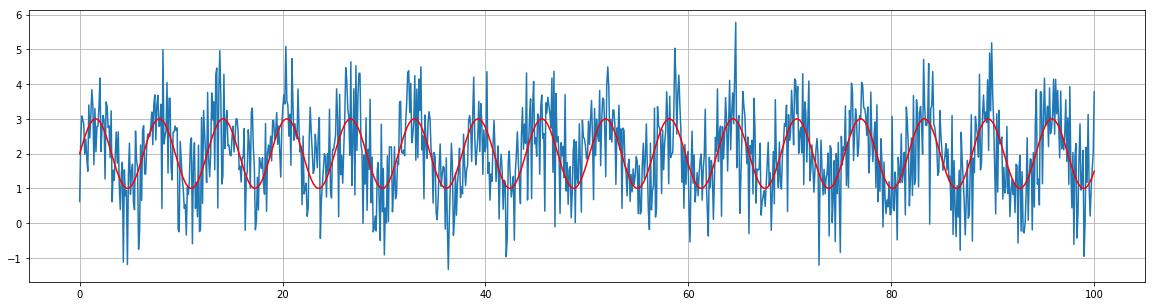

In [3]:
# plot
plt.figure(figsize=(20,5))
plt.plot(x, y, x, sinx+noise_m, 'r')
plt.grid(True)

In [4]:
def segment(X, length):
    ''' 
    segment a given list of moments to list of chunks each with size length 
    to do: try to implement overlap option
    '''
    n_segs = len(X)//length
#     return [X[i+(i+1)*length-op:i+(i+2)*length-op] for i in range(0, n_segs)]
    return [X[i*length:(i+1)*length] for i in range(0, n_segs)]

In [5]:
# split it to train and test
slice_ind = int(n_samples*0.8)
train_x, train_y, test_x, test_y, smooth_y_train, smooth_y_test = x[:slice_ind], y[:slice_ind], x[slice_ind:], y[slice_ind:], smooth[:slice_ind], smooth[slice_ind:]
train_n, test_n = len(train_x), len(test_x)

# chunk it to each small window
seq_len = 3
# note train_y is actually the value
train_y = np.array(segment(train_y, seq_len))
train_y = train_y.reshape(-1, seq_len, 1)

In [6]:
train_y.shape

(266, 3, 1)

#### Build model

In [7]:
%%time
tf.reset_default_graph()
state_size = 100
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size, forget_bias=1.)

X = tf.placeholder(tf.float64, [None, seq_len, 1])#, name = 'input')
Y = tf.placeholder(tf.float64, [None, seq_len, 1])#, name = 'output')

# dynamic rnn
output, last_states = tf.nn.dynamic_rnn(inputs=X, cell=lstm_cell, dtype=tf.float64)
pred = tf.contrib.layers.fully_connected(inputs=output, num_outputs=1)

# loss
label = np.roll(train_y, 1) # shift to create next time step
loss = tf.losses.mean_squared_error(label, pred)

# optimzier
opt = tf.train.AdamOptimizer().minimize(loss)


# session
sess = tf.Session()
# Initializing the variables
sess.run(tf.global_variables_initializer())

# iterate
for i in range(1000):
    print(i+1, end='\r')
    p, l, _ = sess.run([pred, loss, opt], feed_dict={X: train_y, Y: label})

CPU times: user 9.11 s, sys: 760 ms, total: 9.87 s
Wall time: 8.15 s


In [8]:
p.shape

(266, 3, 1)

In [9]:
label.shape

(266, 3, 1)

In [10]:
train_x.shape

(800,)

In [11]:
smooth_y_train.shape

(800,)

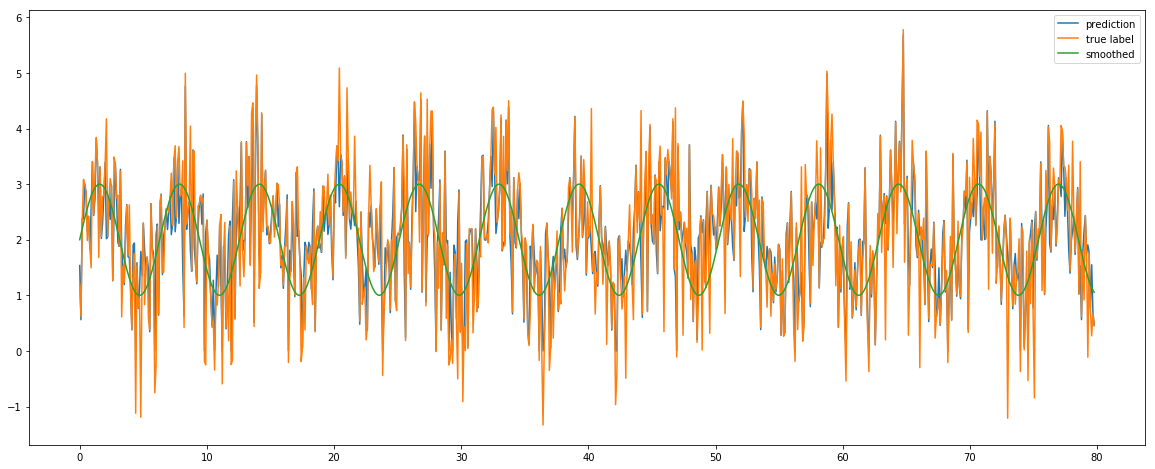

In [12]:
plt.figure(figsize=(20,8))
if seq_len%2 == 0:
    pl = -train_x.shape[0]
else:
    pl = 2
plt.plot(train_x[:-pl], p.reshape(-1), train_x[:-pl], label.reshape(-1), train_x[:-pl], smooth_y_train.reshape(-1)[:-pl])
plt.legend(['prediction', 'true label', 'smoothed'])

#### Test model

In [13]:
# make test set
test_y = np.array(segment(test_y, seq_len))
test_y = test_y.reshape(-1, seq_len, 1)
test_y.shape

(66, 3, 1)

In [14]:
test_pred = sess.run([pred], feed_dict={X: test_y})[0]#, Y: np.roll(test_y,1)})[0]
test_pred = test_pred.reshape(-1)

In [15]:
test_x.shape

(200,)

In [16]:
test_pred.shape

(198,)

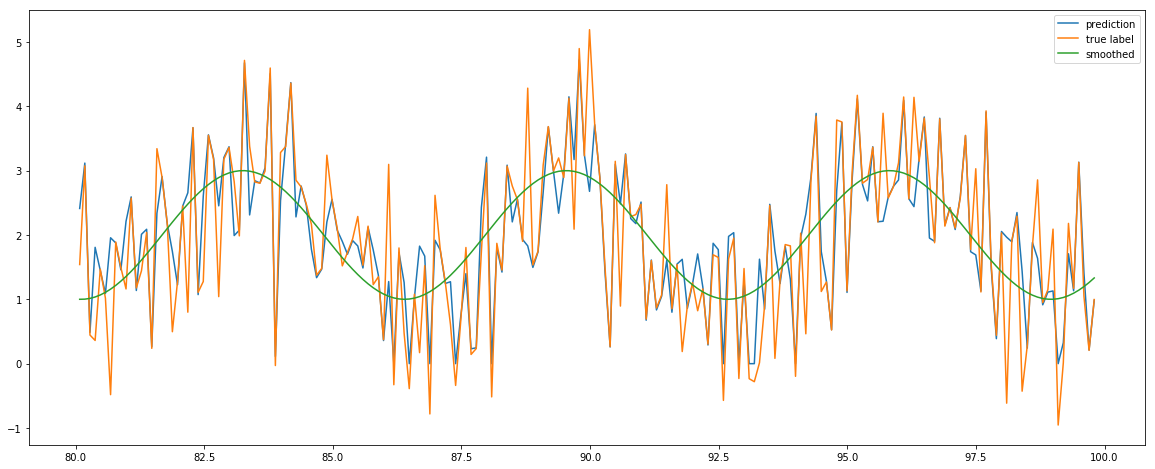

In [17]:
plt.figure(figsize=(20,8))
plt.plot(test_x[:-pl], test_pred, test_x[:-pl], np.roll(test_y,1).reshape(-1), test_x[:-pl], smooth_y_test.reshape(-1)[:-pl])
plt.legend(['prediction', 'true label', 'smoothed'])

#### Generate true prediction instead of relying on true input

In [18]:
test_y.shape

(66, 3, 1)

In [19]:
%%time
import copy
# loop over each sequence
n_op = 0

# define how many sequences we want to generate
gen_len = 20
assert gen_len < test_y.shape[0], 'sequence to be generated out of range'
test_y1 = copy.deepcopy(test_y[:gen_len])
for i in range(1, gen_len*seq_len):
    print(i, end='\r')
    pred_i = sess.run([pred], feed_dict={X: test_y1})[0]
    # remake the input
    test_y1 = test_y1.reshape(-1)
    test_y1[i] = pred_i.reshape(-1)[i-1]
    test_y1 = test_y1.reshape(-1, seq_len, 1)

test_x1 = test_x[:gen_len*seq_len].reshape(-1)
test_y1 = test_y1.reshape(-1)
true_test_pred = pred_i.reshape(-1)

CPU times: user 116 ms, sys: 24 ms, total: 140 ms
Wall time: 77.8 ms


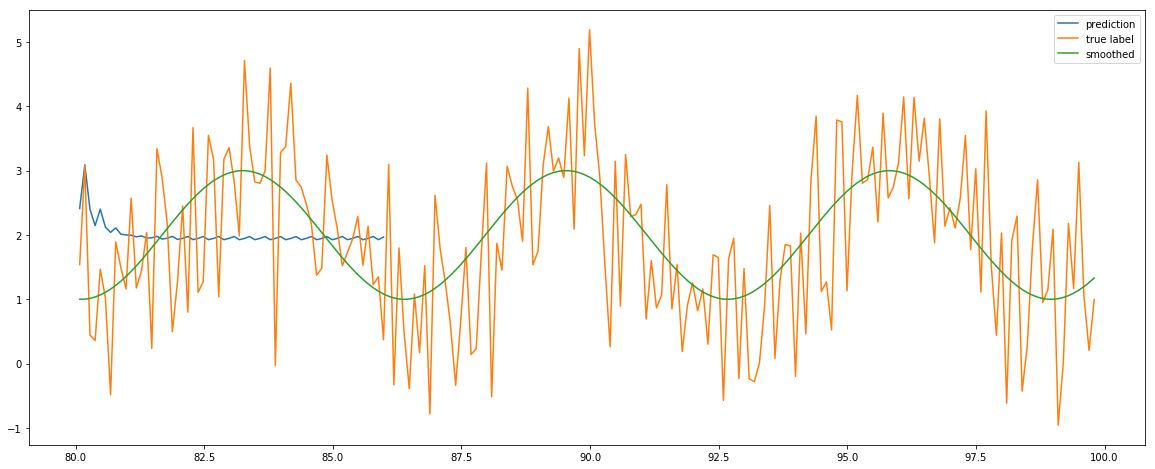

In [20]:
plt.figure(figsize=(20,8))
plt.plot(test_x1, true_test_pred, test_x[:-pl], np.roll(test_y,1).reshape(-1), test_x[:-pl], smooth_y_test.reshape(-1)[:-pl])
plt.legend(['prediction', 'true label', 'smoothed'])

---